# Federated Learning - MNIST - Role: Data Owner

This is an auxiliar notebook to populate the network. Here we introduce an extra role: the Data Owner who is responsible to populate the NetworkGrid. 

*Important note: This notebook is only for testing purposes. In a real scenario, the data is already on the network.*

**Goal: Populate remote GridNodes with labeled tensors**

In this notebbok, we will show how to populate a GridNode with labeled data, so it will be used later (link to second part) by people interested in train models.

In particular, we will consider that two Data Owners (Alice & Bob) want to populate their nodes with some data from the well-known MNIST dataset.

###  Step.0  Previous setup

Components:

 - PyGrid Network      http://network:7000
 - PyGrid Node Alice (http://alice:5000)
 - PyGrid Node Bob   (http://bob:5001)

This notebook assumes that these components are running in background. See [instructions](../README.md) for more details.

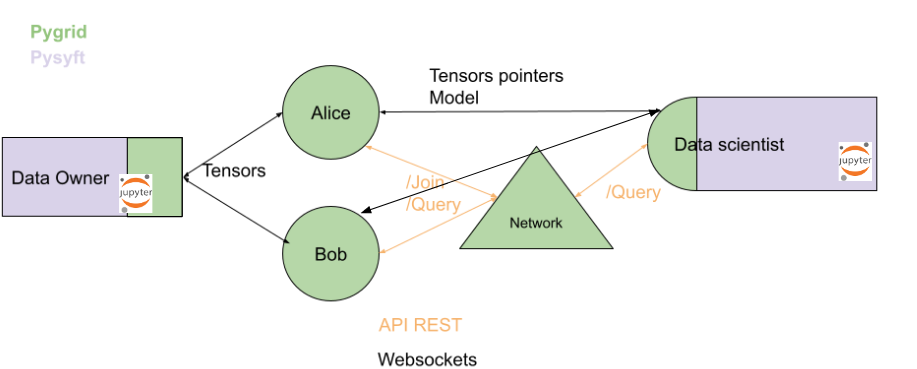

In [1]:
from IPython.display import Image
Image("./img/data_centric_schema.png", width = 900,height = 300)

### Import dependencies
Here we import core dependencies

In [1]:
import syft as sy
from syft.grid.clients.data_centric_fl_client import DataCentricFLClient  # websocket client. It sends commands to the node servers

import torch
import torchvision
from torchvision import datasets, transforms

import requests
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler


# we create some dicts to store losses
torch_loss_stats = {
    'torch loss train': [],
    'torch loss val': []
}

syft_loss_stats = {
    'syft loss train': [],
    'syft loss val': []
}

### Syft and client configuration
Now we hook Torch and connect the clients to the servers

In [2]:
# address
alice_address = "http://0.0.0.0:5001" 
bob_address   = "http://0.0.0.0:5000"

In [3]:
hook = sy.TorchHook(torch)

# Connect direcly to grid nodes
compute_nodes = {}

compute_nodes["Alice"] = DataCentricFLClient(hook, alice_address)
compute_nodes["Bob"]   = DataCentricFLClient(hook, bob_address) 

# Check if they are connected
for key, value in compute_nodes.items(): 
    print("Is " + key + " connected?: " + str(value.ws.connected))

Is Alice connected?: True
Is Bob connected?: True


### Step. 1  Load dataset
Download (and load) the MNIST dataset

In [4]:
N_SAMPLES = 10000  # Number of samples
MNIST_PATH = './dataset'  # Path to save MNIST dataset

# Define a transformation.
transform = transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)),  #  mean and std 
                              ])

# Download and load MNIST dataset
trainset = datasets.MNIST(MNIST_PATH, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=N_SAMPLES, shuffle=True)

dataiter = iter(trainloader)
images_train_mnist, labels_train_mnist = dataiter.next()  # Train images and their labels

### Step. 2  Split dataset

We split our dataset in chunks. We will send half of the chunks to one worker node and the other half to the other.

In [5]:
number_chunks = int(len(images_train_mnist) / len(compute_nodes))
number_chunks

5000

In [5]:
images_train_mnist = torch.split(images_train_mnist, number_chunks, dim=0 ) #tuple of chunks (dataset / number of nodes)
labels_train_mnist = torch.split(labels_train_mnist, int(len(labels_train_mnist) / len(compute_nodes)), dim=0 )  #tuple of chunks (labels / number of nodes)

... and we add tags to them so that we can search them later

In [6]:
for index, _ in enumerate(compute_nodes):
        
    images_train_mnist[index]\
        .tag("#X", "#mnist", "#dataset")\
        .describe("The input datapoints to the MNIST dataset.") 
    
    
    labels_train_mnist[index]\
        .tag("#Y", "#mnist", "#dataset") \
        .describe("The input labels to the MNIST dataset.")


### Step. 3  Sending our tensor to grid nodes

We can consider the previous steps as data preparation, i.e., in a more realistic scenario Alice and Bob would already have their data, so they just would need to load their tensors into their nodes.

In [7]:
for index, key in enumerate(compute_nodes):
    
    print("Sending data to", key)
    
    images_train_mnist[index].send(compute_nodes[key], garbage_collect_data=False)
    labels_train_mnist[index].send(compute_nodes[key], garbage_collect_data=False)

Sending data to Alice
Sending data to Bob


If everything is ok, tensors must be hosted in the nodes. GridNode have a specific endpoint to request what tensors are hosted. Let's check it!

In [8]:
print("Alice's tags: ", requests.get(alice_address + "/data-centric/dataset-tags").json())
print("Bob's tags: ",   requests.get(bob_address   + "/data-centric/dataset-tags").json())

Alice's tags:  ['#dataset', '#X', '#Y', '#mnist']
Bob's tags:  ['#X', '#Y', '#dataset', '#mnist']


This notebook is based on the reference example of [PyGrid Network Data-Centric](https://github.com/OpenMined/PyGrid)